In [1]:
# Load model directly
from transformers import AutoTokenizer
import pandas as pd
import polars as pl

tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
# tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MLM")
# tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
# tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

/home/visanim/.cache/pypoetry/virtualenvs/lotus-hypersketching-ruHkzsWs-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
lotus = pd.read_csv("./data/molecules/230106_frozen_metadata.csv.gz", low_memory=False)

In [3]:
lotus["wd_molecule"] = "wd:" + lotus.structure_wikidata.str.extract(r"(Q\d+)")


wd = lotus[
    [
        "wd_molecule",
        "structure_smiles_2D",
    ]
].drop_duplicates()

In [4]:
embedding = tokenizer(
    list(wd["structure_smiles_2D"].values),
    max_length=1024,
    padding="max_length",
    return_tensors="np",
)["input_ids"]

In [5]:
embedding = {wd["wd_molecule"].values[i]: embedding[i] for i in range(len(wd))}

In [6]:
df = pl.from_dict(embedding).transpose(include_header=True).to_pandas()
df.set_index("column", inplace=True)

<Axes: xlabel='PC1', ylabel='PC2'>

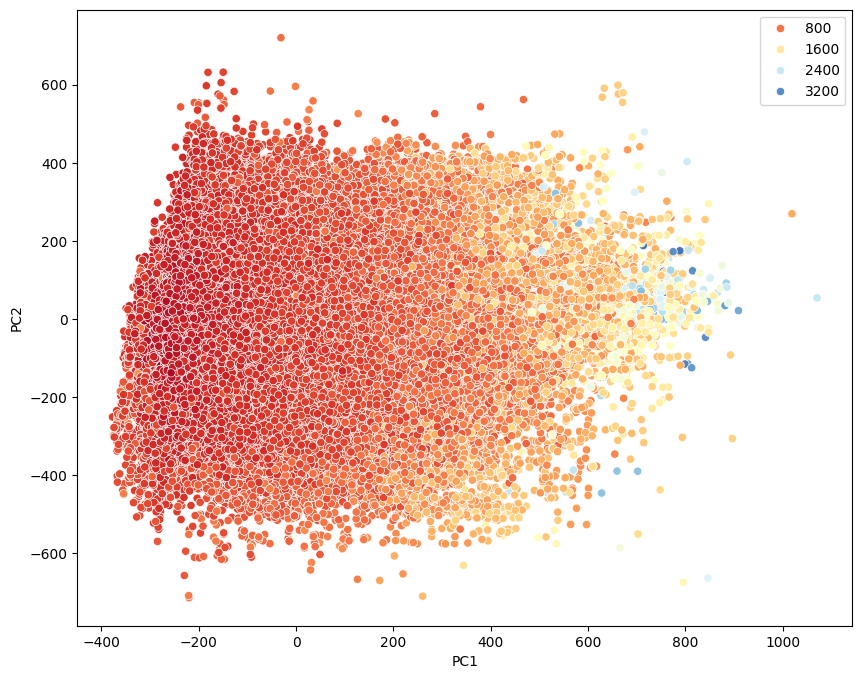

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca_fitted = pca.fit_transform(df)

pca_fitted = pd.DataFrame(pca_fitted, index=df.index, columns=["PC1", "PC2"])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
color = (
    lotus[lotus.wd_molecule.isin(pca_fitted.index)]
    .drop_duplicates(subset="wd_molecule")
    .structure_exact_mass
)

sns.scatterplot(
    x=pca_fitted["PC1"],
    y=pca_fitted["PC2"],
    hue=color.values,
    palette="RdYlBu",
)

<Axes: xlabel='PC1', ylabel='PC2'>

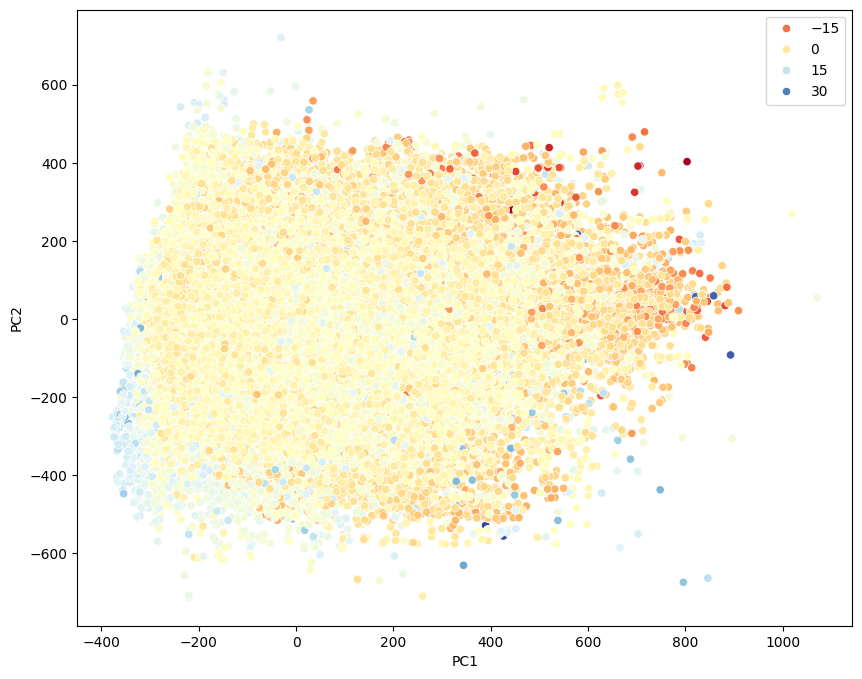

In [11]:
plt.figure(figsize=(10, 8))
color = (
    lotus[lotus.wd_molecule.isin(pca_fitted.index)]
    .drop_duplicates(subset="wd_molecule")
    .structure_xlogp
)

sns.scatterplot(
    x=pca_fitted["PC1"],
    y=pca_fitted["PC2"],
    hue=color.values,
    palette="RdYlBu",
)

In [8]:
from sklearn.decomposition import PCA

pca_tsne = PCA(n_components=50)

pca_tsne_fitted = pca_tsne.fit_transform(df)

In [9]:
pca_tsne_fitted = pd.DataFrame(pca_tsne_fitted, index=df.index)
pca_tsne_fitted_sub_sample = pca_tsne_fitted.sample(50000, random_state=42)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.005s...
[t-SNE] Computed neighbors for 50000 samples in 0.620s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sam

<Axes: >

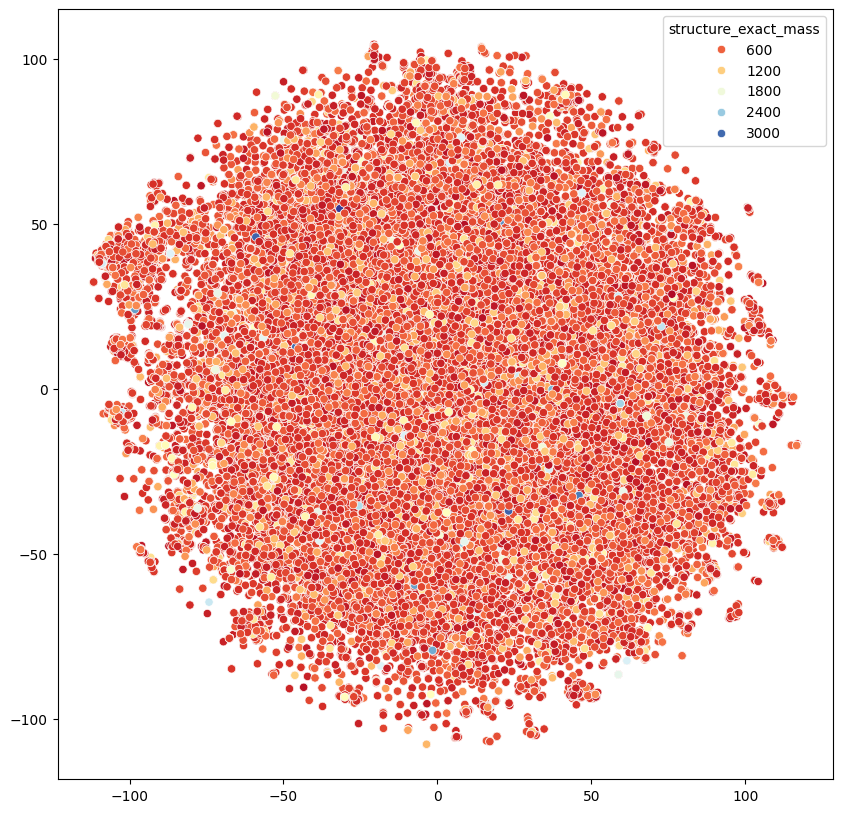

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    verbose=2,
    random_state=42,
)

tsne_fitted = tsne.fit_transform(pca_tsne_fitted_sub_sample)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
color = (
    lotus[lotus.wd_molecule.isin(pca_tsne_fitted_sub_sample.index)]
    .drop_duplicates(subset="wd_molecule")
    .structure_exact_mass
)

sns.scatterplot(
    x=tsne_fitted[:, 0],
    y=tsne_fitted[:, 1],
    hue=color,
    palette="RdYlBu",
)